# Eye Color Changing
### Methods:
* Hough circle
* Mediapipe face mesh
* HSV color factors
#### 1. Import libraries

In [1]:
import cv2 as cv
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
# os.mkdir("dataset/")
# cfd = os.path.join("CFD Version 3.0/")
# dataset_path = os.path.join("dataset/")
# cfd_list = os.listdir(cfd)
# for folder in cfd_list:
#     files = os.listdir(f"CFD Version 3.0/{folder}/")
#     if len(files) > 1:
#         shutil.move(f"CFD Version 3.0/{folder}/{files[1]}", dataset_path)
#     else:
#         shutil.move(f"CFD Version 3.0/{folder}/{files[0]}", dataset_path)

In [3]:
mp_drawing = mp.solutions.drawing_utils # Drawing Helper
mp_holistic = mp.solutions.holistic # Face boundaries

#### 2. Real-time face mesh using camera

In [4]:
cam = cv.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cam.isOpened():
        ret, frame = cam.read()
        # Mediapipe holistic will work on RGB images
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        
        result = holistic.process(image)
        
        # So after the holistic process it's necessary to change the RGB format into BGR again only for using camera
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        
        # 1. Drawing landmarks on face
        mp_drawing.draw_landmarks(image, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=2, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=2, circle_radius=1)
                                 )
        
        cv.imshow('Face Mesh', image)
        
        if cv.waitKey(1) & 0xFF == ord('c'):
            cv.imwrite("my_image.jpg", image)
            print('Image captured')
        if cv.waitKey(1) & 0xFF == ord('q'):
            print('Closing webcam...')
            break
        
cam.release()
cv.destroyAllWindows()

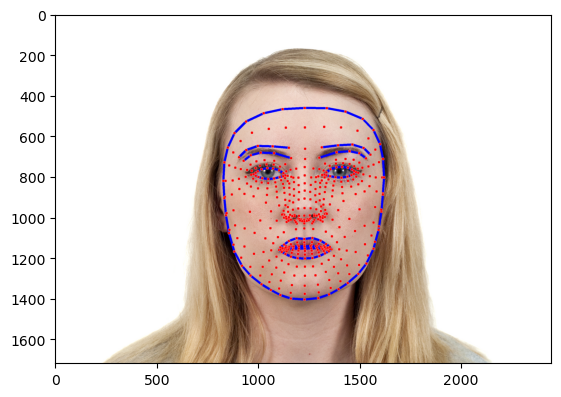

In [5]:
test_image = cv.imread("dataset/CFD-WF-244-163-N.jpg")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
    result = holistic.process(test_image)

    mp_drawing.draw_landmarks(test_image, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                 mp_drawing.DrawingSpec(color=(255,0,0), thickness=10, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(0,0,255), thickness=10, circle_radius=1))
    
plt.imshow(test_image)
plt.show()

#### 3. Executed landmarks using google guide and defining functions

In [6]:
left_eye = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
right_eye = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

def eye_landmarker(rgb_image, num_landmark, output=1, color=(50, 100, 255)):
    with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
        result = holistic.process(rgb_image)
    
    if type(num_landmark) == int:
        x = int((result.face_landmarks.landmark[num_landmark].x)*rgb_image.shape[1])
        y = int((result.face_landmarks.landmark[num_landmark].y)*rgb_image.shape[0])
        cv.circle(rgb_image, (x, y), radius=5, color=color, thickness=10)
    elif type(num_landmark) == list:
        x = []
        y = []
        for val in num_landmark:
            x.append(int((result.face_landmarks.landmark[val].x)*rgb_image.shape[1]))
            y.append(int((result.face_landmarks.landmark[val].y)*rgb_image.shape[0]))
        for i in range(len(x)):    
            cv.circle(rgb_image, (x[i], y[i]), radius=5, color=color, thickness=5)
    
    # Optional
    if output==1:
        # Returns the image with a circle pointed on the specific area
        return rgb_image
    elif output==2:
        # Returns only the the coordinates of the image
        return x, y

def eye_pixels(image, left_eye, right_eye):
    left_eye_landmark = eye_landmarker(image, left_eye, 2)
    right_eye_landmark = eye_landmarker(image, right_eye, 2)

    left_eye_pixel = []
    for x, y in zip(left_eye_landmark[0], left_eye_landmark[1]):
        left_eye_pixel.append([x, y])

    right_eye_pixel = []
    for x, y in zip(right_eye_landmark[0], right_eye_landmark[1]):
        right_eye_pixel.append([x, y])
        
    return(left_eye_pixel, right_eye_pixel)
    
def eye_tracker(image_path, left_eye, right_eye, flag=True):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_copy = image.copy()
    
    left_eye, right_eye = eye_pixels(image, left_eye, right_eye)
    
    # For morphological analysis and Hough circle transform, the image should be converted to gray scale
    mask = np.zeros(image_copy.shape, dtype=np.uint8)
    cv.fillPoly(mask, [np.array(left_eye, dtype=np.int32)], (255, 255, 255))
    cv.fillPoly(mask, [np.array(right_eye, dtype=np.int32)], (255, 255, 255))
    
    masked_eyes = cv.bitwise_and(image_copy, mask)
    if flag:
        return(masked_eyes)
    else:
        return(mask)
    
def hough_transform(image, p1, p2, minR, maxR):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.3, 30, param1=p1, param2=p2, minRadius=minR, maxRadius=maxR)
    circles = np.uint16(np.around(circles))
    for c in circles[0]:
        cv.circle(image, (c[0], c[1]), c[2], (0,255,0), 10)
        cv.circle(image, (c[0], c[1]), 1, (0,255,0), 10)
    
    circles = np.uint16(np.around(circles))
    return(circles)

def iris_tracker(img_path):
    tracked_img = eye_tracker(img_path, left_eye, right_eye)
    circles = hough_transform(tracked_img, 100, 40, 30, 0)
    iris_mask = np.zeros(tracked_img.shape, np.uint8())
    for c in circles[0]:
        cv.circle(iris_mask, (c[0], c[1]), c[2], (255,255,255), -1)
        cv.circle(iris_mask, (c[0], c[1]), 1, (255,255,255), -1)
    iris = np.bitwise_and(iris_mask, tracked_img)
    return(iris)

##### 4. Below cells are only for visualisation * Their functions are implemented above *

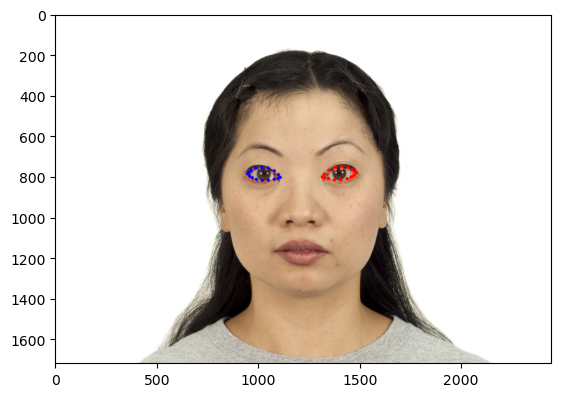

In [7]:
test_image = cv.imread("dataset/CFD-AF-200-228-N.jpg")
left_eye_landmark = eye_landmarker(test_image, left_eye, 2)
right_eye_landmark = eye_landmarker(test_image, right_eye, 2)

left_eye_pixel = []
for x, y in zip(left_eye_landmark[0], left_eye_landmark[1]):
    left_eye_pixel.append([x, y])
    
right_eye_pixel = []
for x, y in zip(right_eye_landmark[0], right_eye_landmark[1]):
    right_eye_pixel.append([x, y])
    

test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)    
eye_landmarker(test_image, right_eye, 1, (255,0,0))
eye_landmarker(test_image, left_eye, 1, (0,0,255))
plt.imshow(test_image)
plt.show()

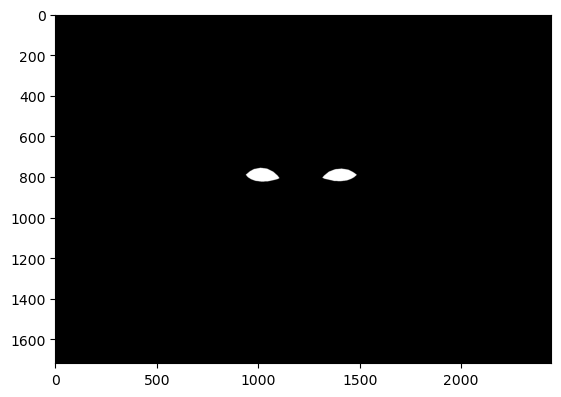

In [8]:
mask = np.zeros(test_image.shape, dtype=np.uint8)
cv.fillPoly(mask, [np.array(left_eye_pixel, dtype=np.int32)], (255,255,255))
cv.fillPoly(mask, [np.array(right_eye_pixel, dtype=np.int32)], (255,255,255))
plt.imshow(mask, cmap='gray')
plt.show()

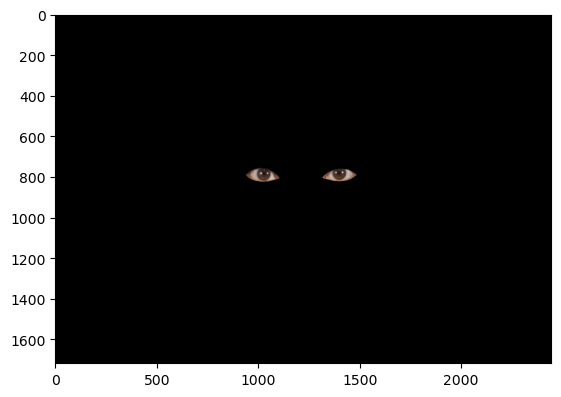

In [9]:
test_image = cv.imread("dataset/CFD-AF-200-228-N.jpg")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)
# test_image = cv.GaussianBlur(test_image, (5, 5), 1.5)
gt = cv.bitwise_and(test_image, mask)
plt.imshow(gt, cmap='gray')
plt.show()

#### 5. From visualized results, now it is possible to use Hough tranform to find the pupil

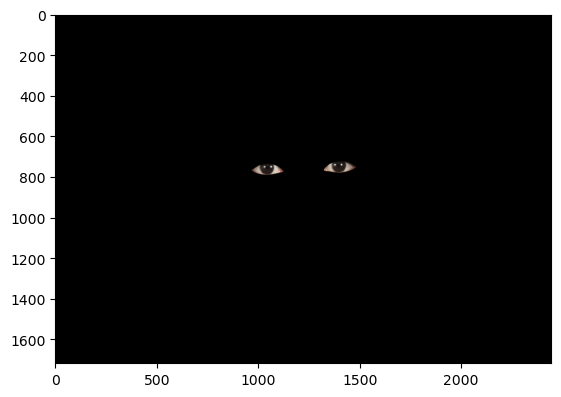

In [10]:
# Testing out functions to make sure it's working well
img_path = "dataset/CFD-BF-213-188-N.jpg"
tracked_img = eye_tracker(img_path, left_eye, right_eye)
plt.imshow(tracked_img)
plt.show()

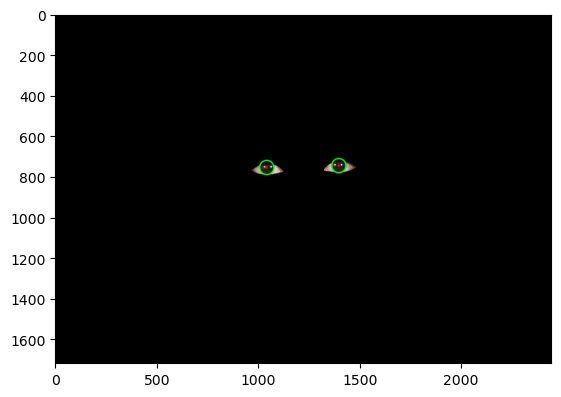

In [11]:
img_path = "dataset/CFD-BF-213-188-N.jpg"
tracked_img = eye_tracker(img_path, left_eye, right_eye)
circles = hough_transform(tracked_img, 60, 40, 20, 0)

for c in circles[0]:
    cv.circle(tracked_img, (c[0], c[1]), c[2], (0,255,0), 5)
    cv.circle(tracked_img, (c[0], c[1]), 1, (255,0,0), 10)

plt.imshow(tracked_img)
plt.show()

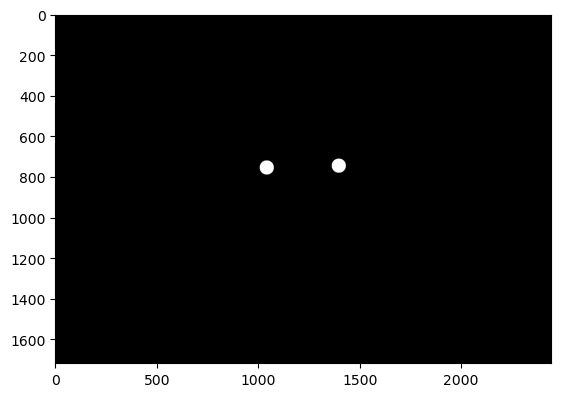

In [12]:
iris_mask = np.zeros(tracked_img.shape, np.uint8())
for c in circles[0]:
    cv.circle(iris_mask, (c[0], c[1]), c[2], (255,255,255), -1)
    cv.circle(iris_mask, (c[0], c[1]), 1, (255,255,255), -1)
    
plt.imshow(iris_mask)
plt.show()

#### 6. Executing iris from image and changing the color using HSV

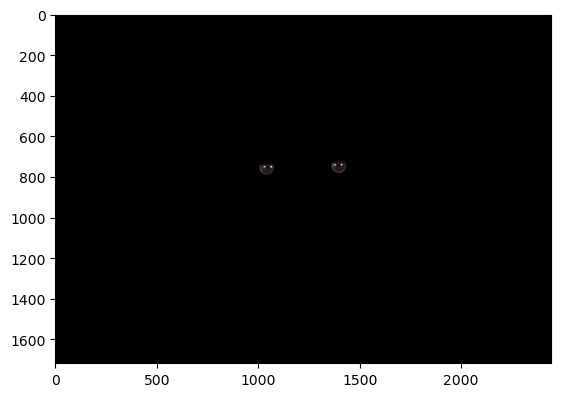

In [13]:
img_path = "dataset/CFD-BF-213-188-N.jpg"
iris = iris_tracker(img_path)
plt.imshow(iris)
plt.show()

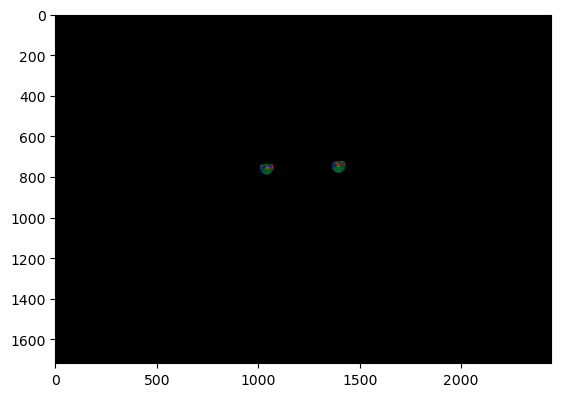

In [14]:
hsv_iris = cv.cvtColor(iris, cv.COLOR_RGB2HSV)
plt.imshow(hsv_iris)
plt.show()

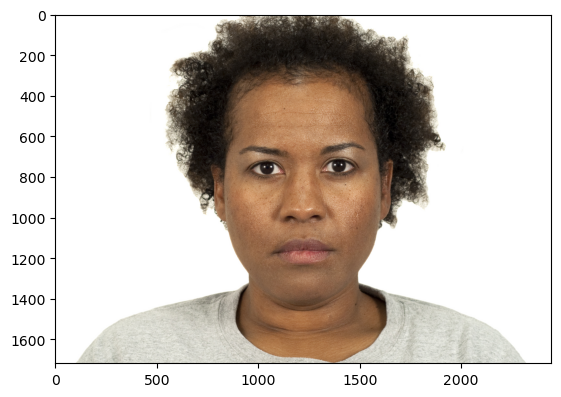

In [15]:
img_path = "dataset/CFD-BF-213-188-N.jpg"
img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
eyes = eye_tracker(img_path, left_eye, right_eye)
circles = hough_transform(eyes, 100, 40, 30, 0)
plt.imshow(img)
plt.show()

In [16]:
hsv_good_colors = [100, 1, 200, 250, 50, 13, 150, 290, 310]
# for converting brown eye into black:
    # hsv_mask = hsv_iris[:, :, 2] != 0
    # hsv_iris[hsv_mask, 2] -= 20

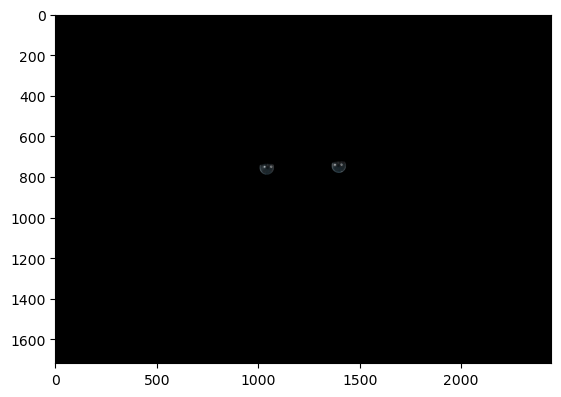

In [17]:
img_path = "dataset/CFD-BF-213-188-N.jpg"
img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
iris = iris_tracker(img_path)
hsv_iris = cv.cvtColor(iris, cv.COLOR_RGB2HSV)
hsv_mask = hsv_iris[:, :, 0] != 0
hsv_iris[hsv_mask, 0] = 100
hsv_mask = hsv_iris[:, :, 2] != 0
hsv_iris[hsv_mask, 2] += 5
new_iris = cv.cvtColor(hsv_iris, cv.COLOR_HSV2RGB)
plt.imshow(new_iris)
plt.show()

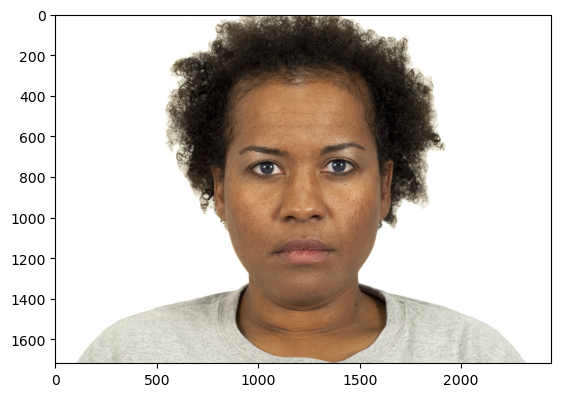

In [18]:
img_path = "dataset/CFD-BF-213-188-N.jpg"
tracked_img = eye_tracker(img_path, left_eye, right_eye, False)

iris_mask = np.zeros(tracked_img.shape, np.uint8())
for c in circles[0]:
    cv.circle(iris_mask, (c[0], c[1]), c[2], (2-55,255,255), -1)
    cv.circle(iris_mask, (c[0], c[1]), 1, (255,255,255), -1)

# x = np.bitwise_and(tracked_img, iris_mask)
y = np.bitwise_or(new_iris, img)

plt.imshow(y)
plt.show()

#### 7. Creating a function for visualizing other outputs

In [19]:
def hough_transform(image, minDist, p1, p2, minR, maxR):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.3, minDist, param1=p1, param2=p2, minRadius=minR, maxRadius=maxR)
    circles = np.uint16(np.around(circles))
    for c in circles[0]:
        cv.circle(image, (c[0], c[1]), c[2], (0,255,0), 10)
        cv.circle(image, (c[0], c[1]), 1, (0,255,0), 10)
    
    circles = np.uint16(np.around(circles))
    return(circles)

In [20]:
def iris_tracker_combiner(img_path, minDist, p1, p2, minR, maxR):
    tracked_img = eye_tracker(img_path, left_eye, right_eye)
    circles = hough_transform(tracked_img, minDist,p1, p2, minR, maxR)
    iris_mask = np.zeros(tracked_img.shape, np.uint8())
    for c in circles[0]:
        cv.circle(iris_mask, (c[0], c[1]), c[2], (255,255,255), -1)
        cv.circle(iris_mask, (c[0], c[1]), 1, (255,255,255), -1)
    iris = np.bitwise_and(iris_mask, tracked_img)
    return(iris)

In [21]:
def combiner(img_path, hue, value=10, minDist=30, p1=100, p2=40, minR=30, maxR=0):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    iris = iris_tracker_combiner(img_path, minDist, p1, p2, minR, maxR)
    hsv_iris = cv.cvtColor(iris, cv.COLOR_RGB2HSV)
    hsv_mask = hsv_iris[:, :, 0] != 0
    hsv_iris[hsv_mask, 0] = hue
    hsv_mask = hsv_iris[:, :, 2] != 0
    hsv_iris[hsv_mask, 2] += value
    new_iris = cv.cvtColor(hsv_iris, cv.COLOR_HSV2RGB)
    y = np.bitwise_or(new_iris, img)
    plt.imshow(y)
    plt.show()

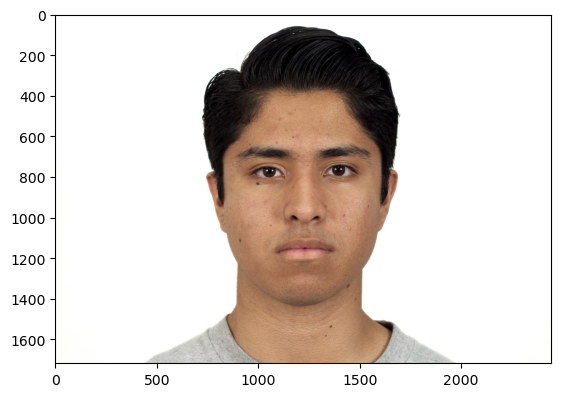

In [22]:
img_path = "dataset/CFD-LM-216-082-N.jpg"
img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

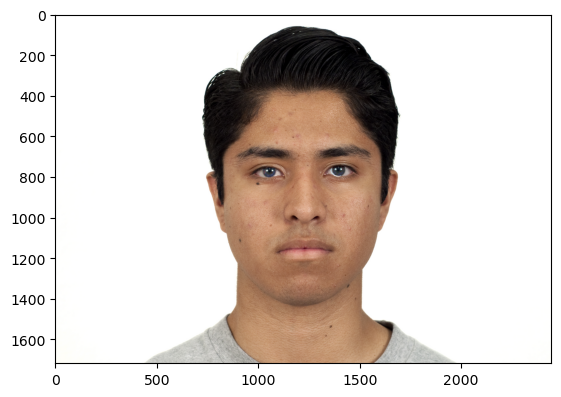

In [23]:
combiner(img_path, hue=100, value=15, minDist=30, p1=140, p2=35, minR=10, maxR=0)